In [4]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
import scipy.io
import random
import matplotlib.cm as cm#colormap
import scipy.misc

# Multiclass classification

In [5]:
datafile = 'data/ex3data1.mat'
data = scipy.io.loadmat(datafile)
X, y = data['X'], data['y']
#X is 5000*400, y is 5000*1
X = np.hstack([np.ones((X.shape[0], 1)), X])
y = y.reshape(-1, 1)
m = y.size

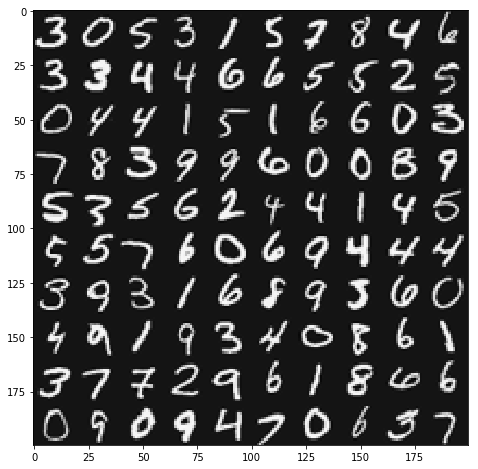

In [3]:
#display the data
def displayData():
    #pick 100 rows from X
    #each row of X is 400 (20*20)
    ncol, nrow = 10, 10
    width, height = 20, 20
    bigPic = np.zeros((nrow * height, ncol * width))
    index = random.sample(range(X.shape[0]), nrow*ncol)
    cur_row, cur_col = 0,0
    for i in index:
        if cur_col == ncol:
            cur_row += 1
            cur_col = 0
        curPic = X[i,1:].reshape(height, width).T
        bigPic[cur_row*height:(cur_row + 1)*height, cur_col*width:(cur_col + 1)*width] = curPic
        cur_col += 1
    fig = plt.figure(figsize = (8,8))
    img = scipy.misc.toimage(bigPic)
    plt.imshow(img, cmap=cm.Greys_r)
displayData()   

In [6]:
def h(theta, X):
    #X:m*n dimention
    #theta n*1 dimention
    return expit(np.dot(X, theta))
#computeCost
def computeCost(theta, X, y, mylambda = 0.):
    m = X.shape[0]
    return (1./m) * (np.dot((-y).reshape(1,-1), np.log(h(theta, X))) \
                     - np.dot((1-y).reshape(1,-1), np.log(1 - h(theta, X))))\
                     + (mylambda/2./m) * np.dot(theta[1:].T, theta[1:])
def gradient(theta, X, y, mylambda = 0.):
    m = X.shape[0]
    theta = theta.reshape(X.shape[1], -1)
    grad = (1./m) * np.dot(X.T,(h(theta, X) - y))
    #print("X shape: %d %d" %(X.shape[0], X.shape[1]))
    #print("Y shape: %d %d" %(y.shape[0], y.shape[1]))
    #print(theta.shape)
    #print(grad.shape)
    grad[1:] += (mylambda/m)*theta[1:]
    return grad.flatten()

In [7]:
#test case for computeCost and gradient
test_theta = np.array([-2, -1 ,1, 2]).reshape(-1, 1)
test_x = np.hstack([np.ones((5,1)), np.array(range(1, 16)).reshape(3, 5).T/10.0])
test_y = np.array([1,0,1,0,1]).reshape(-1, 1)
test_cost = computeCost(test_theta, test_x, test_y, mylambda=3.)
print("Expected cost: 2.534819, my cost: %0.4f" % test_cost)

Expected cost: 2.534819, my cost: 2.5348


In [8]:
#test case for gradient
test_grad = gradient(test_theta, test_x, test_y, mylambda=3.)
print('Expected gradient:0.146561\n -0.548558\n 0.724722\n 1.398003\n');
print('My gradient: %0.6f\n %0.6f\n %0.6f\n %0.6f\n' %(test_grad[0], test_grad[1], test_grad[2], test_grad[3]));

Expected gradient:0.146561
 -0.548558
 0.724722
 1.398003

My gradient: 0.146561
 -0.548558
 0.724722
 1.398003



In [24]:
#optimization
from scipy.optimize import minimize
def optimizeCg(theta, X, y, mylambda = 0.):
    result = minimize(computeCost, theta, args=(X, y, mylambda), method=None, jac=gradient,options={'maxiter':50})
    return result.x

In [26]:
def findTheta(X, y, mylambda = 0.):
    init_theta = np.zeros((X.shape[1], 1))
    #10 class, so 10*X.shape[1] dimentions
    op_theta = np.zeros((10, X.shape[1]))
    y[[i for i in range(y.size) if y[i] == 10]] = 0
    for i in range(10):
        label = (y == i) * 1
        #label[[j for j in range(y.size) if y[j] == i]] = 1
        #print(label.shape, X.shape, init_theta.shape)
        print("Finding theta for class %d" % i)
        cur_theta = optimizeCg(theta = init_theta, X = X, y = label ,mylambda=0.)
        op_theta[i, :] = cur_theta
    print("Done")
    return op_theta

In [27]:
op_theta = findTheta(X,y, mylambda=0.1)
op_theta.shape

Finding theta for class 0
Finding theta for class 1
Finding theta for class 2
Finding theta for class 3
Finding theta for class 4
Finding theta for class 5
Finding theta for class 6
Finding theta for class 7
Finding theta for class 8
Finding theta for class 9
Done


(10, 401)

In [28]:
def oneVsAll(X, theta):
    pred = h(theta, X)
    return np.argmax(pred, axis=1)
pred = oneVsAll(X, op_theta.T)
pred.shape

(5000,)

In [39]:
label = y
label[[i for i in range(label.size) if label[i] == 10]] = 0
print('accuracy = %0.4f' % (np.mean(pred == label.ravel())))

accuracy = 0.9332


# Neural network

In [41]:
weights = scipy.io.loadmat('data/ex3weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [42]:
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
print("Theta1 : {}".format(Theta1.shape))
print("Theta2 : {}".format(Theta2.shape))

Theta1 : (25, 401)
Theta2 : (10, 26)


In [54]:
def nn(X, theta1, theta2):
    z2 = np.dot(X, theta1.T)
    a2 = np.hstack([np.ones((z2.shape[0], 1)), expit(z2)])
    
    z3 = np.dot(a2, theta2.T)
    a3 = expit(z3)
    
    return np.argmax(a3, axis=1)+1

In [57]:
pred_nn = nn(X, Theta1, Theta2)
pred_nn[pred_nn == 10] = 0

print("Accuracy: {}".format(np.mean(pred_nn == y.ravel())))

Accuracy: 0.9752
